In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca



In [2]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                 
55_control    0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain  0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control    0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control   0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain  0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.382762  0.384030  0.377332  0.360165  0.300915  0.340090   
182_CD_plain  0.679910  0.584723  0.722426  0.643867  0.740014  0.650358   
164_CD_plain  0.754656  0.556562  0.694062  0.748334  0.535534  0.133869   
53_CD_plain   0.591140  0.585802  0.750282  0.753309  0.603372  0.469634   
97_CD_plain   0.817125  0.782223  0.854442  0.867360  0.793421  0.726438   

                    C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                            ...             
55_control    1.000000  0.363133  0.374212  0.611161  ...  0.529274   
168_CD_plain  0.311962  0.251356  0.553554  0.441131  ...  0.485551   
72_control    0.648401  0.134017  0.200420  0.679453  ...  0.682864   
120_control   0.579519  0.248934  0.759250  0.755407  ...  0.760504   
258_CD_plain  0.370517  0.244987  0.445387  0.798000  ...  0.601023   
...                ...       ...       ...       ...  ...       ...   
15_CD_plain   0.077348  0.890965  0.261140  0.205779  ...  0.403338   
182_CD_plain  0.468650  0.295686  0.649939  0.609862  ...  0.563382   
164_CD_plain  0.319071  0.154562  0.440487  0.824013  ...  0.278042   
53_CD_plain   0.213239  0.348800  0.485094  0.722492  ...  0.455270   
97_CD_plain   0.246396  0.228774  0.611752  0.699944  ...  0.000000   

              LOC646430  LOC441956     ITGAV    SMCHD1      ASPN    TMEM97  \
Patient_ID                                                                   
55_control          0.0        0.0  0.364776  0.465986  0.922559  0.854193   
168_CD_plain        0.0        0.0  0.522378  0.578564  0.522145  0.692076   
72_control          0.0        0.0  0.042221  0.025102  0.789751  0.878183   
120_control         0.0        0.0  0.517359  0.672548  0.565864  0.505961   
258_CD_plain        0.0        0.0  0.490289  0.858259  0.686037  0.392018   
...                 ...        ...       ...       ...       ...       ...   
15_CD_plain         0.0        0.0  0.568061  0.445374  0.442044  0.695490   
182_CD_plain        0.0        0.0  0.457702  0.485198  0.507829  0.801229   
164_CD_plain        0.0        0.0  0.474069  0.769644  0.659954  0.314433   
53_CD_plain         0.0        0.0  0.506542  0.676451  0.677115  0.459944   
97_CD_plain         0.0        0.0  0.354709  0.345159  0.251259  0.607139   

              LOC389458     PTPN7  RPS12P31  
Patient_ID                                   
55_control     0.224260  0.883418       0.0  
168_CD_plain   0.021080  0.517763       0.0  
72_control     0.048352  0.429987       0.0  
120_control    0.021080  0.490510       0.0  
258_CD_plain   0.021080  0.633386       0.0  
...                 ...       ...       ...  
15_CD_plain    0.021080  0.324311       0.0  
182_CD_plain   0.021080  0.574480       0.0  
164_CD_plain   0.167705  0.847694       0.0  
53_CD_plain    0.021080  0.659798       0.0  
97_CD_plain    0.132905  0.733472       0.0  

[182 rows x 220 columns]

In [3]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
253_CD_plain       0.869185  0.841880  0.930171  0.886737  0.835678  0.297964   
105_CD_plain       0.853562  0.933532  0.942213  0.794578  0.890482  0.206529   
2_CD_plain         0.165531  0.141475  0.263684  0.198091  0.160503  0.888878   
184_CD_plain       0.717121  0.660314  0.769417  0.752737  0.694874  0.514735   
312_CD_plain       0.730072  0.722909  0.713076  0.743545  0.679258  0.308459   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                                 ...             
253_CD_plain       0.668498  0.266670  0.278122  0.933520  ...  0.799811   
105_CD_plain       0.298987  0.350745  0.495663  0.849038  ...  0.843182   
2_CD_plain         0.000000  0.134461  0.989132  0.202203  ...  0.442893   
184_CD_plain       0.692365  0.271127  0.650742  0.694599  ...  0.511169   
312_CD_plain       0.399235  0.129019  0.597529  0.720390  ...  0.498080   
...                     ...       ...       ...       ...  ...       ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...  0.273104   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...  0.540150   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...  0.561707   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...  0.260826   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...  0.598137   

                   LOC646430  LOC441956     ITGAV    SMCHD1      ASPN  \
Patient_ID                                                              
253_CD_plain             0.0        0.0  0.315927  0.580699  0.652889   
105_CD_plain             0.0        0.0  0.233173  0.420656  0.461041   
2_CD_plain               0.0        0.0  1.044816  0.972319  0.998363   
184_CD_plain             0.0        0.0  0.457879  0.591956  0.665982   
312_CD_plain             0.0        0.0  0.583310  0.741909  0.691929   
...                      ...        ...       ...       ...       ...   
107_CD_plain             0.0        0.0  0.511460  0.571813  0.718136   
279_CD_plain             0.0        0.0  0.967121  0.690670  0.586834   
179_CD_plain             0.0        0.0  0.532892  0.827410  0.584298   
70_CD_deep_ulcer         0.0        0.0  0.353435  0.470313  0.693233   
256_CD_deep_ulcer        0.0        0.0  0.550635  0.712620  0.543815   

                     TMEM97  LOC389458     PTPN7  RPS12P31  
Patient_ID                                                  
253_CD_plain       0.283662   0.021080  0.271046       0.0  
105_CD_plain       0.783732   0.050226  0.510625       0.0  
2_CD_plain         0.013298   0.021080  0.674434       0.0  
184_CD_plain       0.460966   0.066515  0.616797       0.0  
312_CD_plain       0.483119   0.021080  0.646119       0.0  
...                     ...        ...       ...       ...  
107_CD_plain       0.624635   0.021080  0.939056       0.0  
279_CD_plain       0.731743   0.021080  0.312015       0.0  
179_CD_plain       0.217127   0.195470  0.876301       0.0  
70_CD_deep_ulcer   0.466546   0.045757  0.799992       0.0  
256_CD_deep_ulcer  0.510634   0.021080  0.597887       0.0  

[78 rows x 220 columns]

In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
compound_model = keras.models.load_model('../data/models/cd_clf')

In [7]:
compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 440)               97240     
                                                                 
 batch_normalization (BatchN  (None, 440)              1760      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 440)               0         
                                                                 
 dense_1 (Dense)             (None, 220)               97020     
                                                                 
 batch_normalization_1 (Batc  (None, 220)              880       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 220)               0

## SHAP evaluation

In [109]:
x_test_scaled.iloc[:2,:2]

AADAC     APOA1
Patient_ID                      
253_CD_plain  0.869185  0.841880
105_CD_plain  0.853562  0.933532

In [8]:
import objects

In [111]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[18])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Calculate SHAP values

In [112]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [113]:
# shap_values

## Independent - 41

In [57]:
idx = 41

In [58]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=False, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [59]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [60]:

with open("../data/models/shap/ind_41", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [61]:
# shap_values[0][0].shape

In [62]:
shap_values = shap_values[0]

In [63]:
# shap_values[0] *= 100000

In [64]:
shap_values

[array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.41512284e+00,  0.00000000e+00,  0.00000000e+00,
         -9.03655844e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -7.94973303e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -1.33942622e+01,  0.00000000e+00,
         -1.04009684e+01, -1.72132434e+01,  0.00000000e+00,
         -4.85707741e-01,  0.00000000e+00, -2.20009349e+01,
          1.52063988e+01, -1.50343927e+01, -1.64052464e+01,
         -4.55435099e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  2.46493438e+00,  0.00000000e+00,
         -1.28127386e+01,  0.00000000e+00,  1.19484745e+01,
          1.32569519e+01,  2.09637143e+01,  0.00000000e+00,
          2.65115908e+01, -2.34315258e+01,  1.53461738e+00,
          1.44360478e+01,  0.00000000e+00,  0.00000000e+00,
         -2.22749935e+01, -2.31617294e+01,  0.00000000e+00,
         -1.60802034e+01,  1.58609927e+0

In [65]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [66]:

patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.588189  0.625309  0.750597  0.746795  0.678619  0.578012   

                         C6   CEACAM7    CHI3L1     ABCC2  ...     MICA  \
Patient_ID                                                 ...            
260_CD_deep_ulcer  0.191236  0.321755  0.595506  0.569387  ...  0.69275   

                   LOC646430  LOC441956     ITGAV    SMCHD1      ASPN  \
Patient_ID                                                              
260_CD_deep_ulcer        0.0        0.0  0.486189  0.553708  0.569272   

                     TMEM97  LOC389458     PTPN7  RPS12P31  
Patient_ID                                                  
260_CD_deep_ulcer  0.530402    0.28222  0.529513       0.0  

[1 rows x 220 columns]

In [74]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:",np.argmax(compound_model.predict(patient)[0]))

1/1 [==============================] - 0s 12ms/step
Prediction probabilities for patient: [0.07070122 0.6113825  0.3179162 ]
1/1 [==============================] - 0s 15ms/step
Predicted class: 1


#### Control

In [68]:
import shap

In [69]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [70]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [71]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [72]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

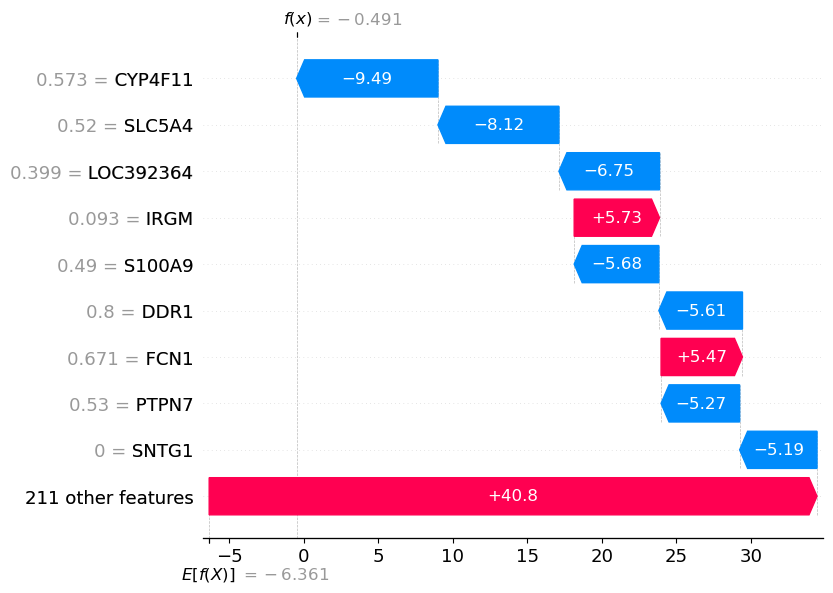

In [73]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 41

In [75]:
idx = 41

In [76]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [77]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [78]:

with open("../data/models/shap/fd_41", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [79]:
# shap_values[0][0].shape

In [80]:
shap_values = shap_values[0]

In [81]:
# shap_values[0] *= 100000

In [82]:
shap_values

[array([[ -9.68526523,  13.76446308, -31.85145105,  53.95341941,
           0.        ,  18.12901329, -21.25053628,  68.55865242,
           0.        , -13.30997914, -17.69046978,   0.        ,
           0.        ,   0.        ,  57.12682094,   0.        ,
           0.        , -42.18744217, -16.18203642, -15.22578677,
         -18.63485659,  24.20229513, -29.72534101, -22.63934033,
           0.        , -47.42081424, -19.61830665, -26.63981203,
           0.        ,  -2.89672796,   0.        , -26.67151937,
           0.66498952,   0.        ,   0.        ,  26.43447293,
          66.05443082,  14.41270053,   0.        ,   8.91471921,
           0.        ,  39.38897164,  77.15799101,   0.        ,
          -6.8795698 ,   0.        ,  11.08564837,  69.83299188,
           0.        ,   0.        ,   0.        ,   6.94389856,
          -3.08706286, -37.45977427,  34.71127429,  19.6901171 ,
          -0.27047367,  30.34290035,  19.26153657,   0.        ,
         -30.73494309, -2

In [83]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [84]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.588189  0.625309  0.750597  0.746795  0.678619  0.578012   

                         C6   CEACAM7    CHI3L1     ABCC2  ...     MICA  \
Patient_ID                                                 ...            
260_CD_deep_ulcer  0.191236  0.321755  0.595506  0.569387  ...  0.69275   

                   LOC646430  LOC441956     ITGAV    SMCHD1      ASPN  \
Patient_ID                                                              
260_CD_deep_ulcer        0.0        0.0  0.486189  0.553708  0.569272   

                     TMEM97  LOC389458     PTPN7  RPS12P31  
Patient_ID                                                  
260_CD_deep_ulcer  0.530402    0.28222  0.529513       0.0  

[1 rows x 220 columns]

In [86]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:",np.argmax(compound_model.predict(patient)[0]))

1/1 [==============================] - 0s 12ms/step
Prediction probabilities for patient: [0.07070122 0.6113825  0.3179162 ]
1/1 [==============================] - 0s 15ms/step
Predicted class: 1


#### Control

In [87]:
import shap

In [88]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [89]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [90]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [91]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

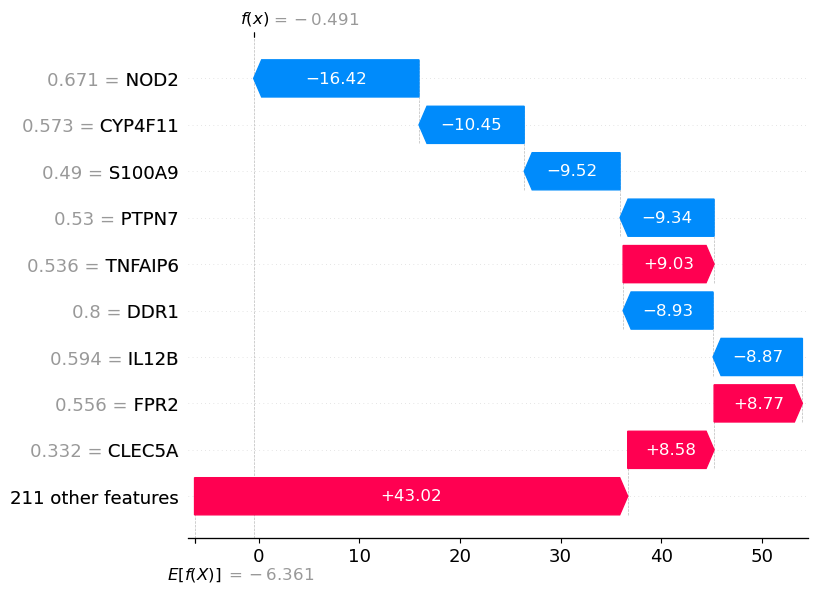

In [92]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 18

In [106]:
idx = 18

In [107]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [108]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [109]:

with open("../data/models/shap/fd_18", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [110]:
# shap_values[0][0].shape

In [111]:
shap_values = shap_values[0]

In [112]:
# shap_values[0] *= 100000

In [113]:
shap_values

[array([[  0.        ,  10.61008399,   0.        ,  24.59402815,
           0.        ,  10.71342985, -35.84179851,  57.12624464,
           0.        ,   0.        ,  -4.80331915,  10.97411957,
           0.        , -71.2286971 ,   0.        ,   0.        ,
         -28.27730587, -32.58430229,   0.        , -11.05224672,
         -11.65347943,   0.        ,   0.        , -19.76738439,
           0.        ,  -7.41147515, -32.05130559,  -2.23168392,
         -27.97474918,   0.        ,   0.        , -32.24078209,
         -35.99410339, -20.42514596,   0.        ,  18.62822175,
         -15.77223597,   0.        ,   0.        ,  39.36158725,
         -27.47181781,   0.        ,  38.71430971,   0.        ,
           0.        , -39.03946254, -17.51760789,   0.        ,
           0.        ,   8.00513038,   0.        , -27.21888125,
         -18.22339093,   0.        ,   4.77346551,  10.84823781,
          30.55076083,   0.        ,   0.        , -12.20905773,
           2.708318  , -4

In [114]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [115]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                                ...             
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...  0.485657   

                  LOC646430  LOC441956    ITGAV    SMCHD1      ASPN    TMEM97  \
Patient_ID                                                                      
46_CD_deep_ulcer        0.0        0.0  0.64322  0.701857  0.924527  0.782324   

                  LOC389458     PTPN7  RPS12P31  
Patient_ID                                       
46_CD_deep_ulcer    0.02108  0.606354       0.0  

[1 rows x 220 columns]

In [117]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:",np.argmax(compound_model.predict(patient)[0]))

1/1 [==============================] - 0s 17ms/step
Prediction probabilities for patient: [0.03760244 0.49271333 0.46968427]
1/1 [==============================] - 0s 16ms/step
Predicted class: 1


#### Control

In [118]:
import shap

In [119]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [120]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [121]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [122]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

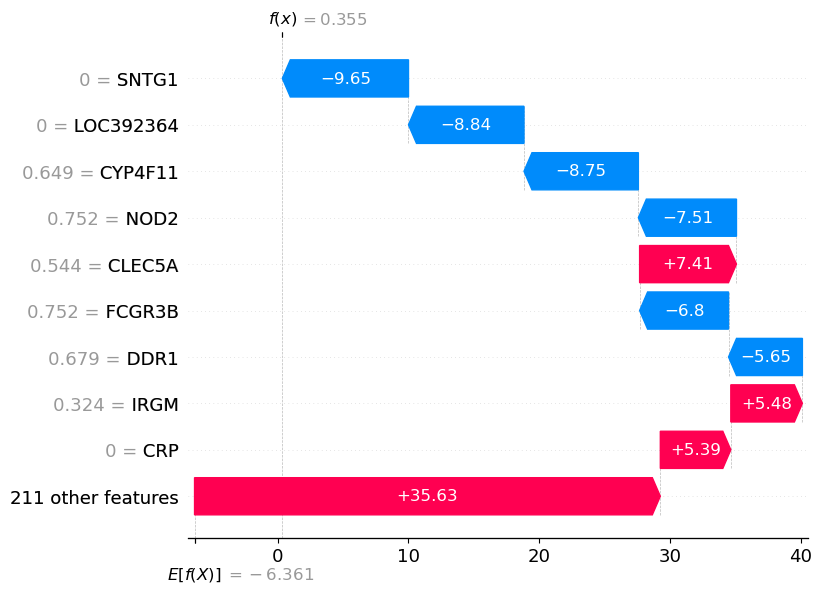

In [123]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Independent - 18

In [93]:
idx = 18

In [94]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=False, specific_indices=[18])

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [95]:


with open("../data/models/shap/ind_18", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [96]:
shap_values = shap_values[0]

In [97]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


In [98]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                                ...             
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...  0.485657   

                  LOC646430  LOC441956    ITGAV    SMCHD1      ASPN    TMEM97  \
Patient_ID                                                                      
46_CD_deep_ulcer        0.0        0.0  0.64322  0.701857  0.924527  0.782324   

                  LOC389458     PTPN7  RPS12P31  
Patient_ID                                       
46_CD_deep_ulcer    0.02108  0.606354       0.0  

[1 rows x 220 columns]

In [99]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:", np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [0.33333333 0.33333333 0.33333333]
Predicted class: 0


#### Control

In [100]:
import shap

In [101]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [102]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [103]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [104]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

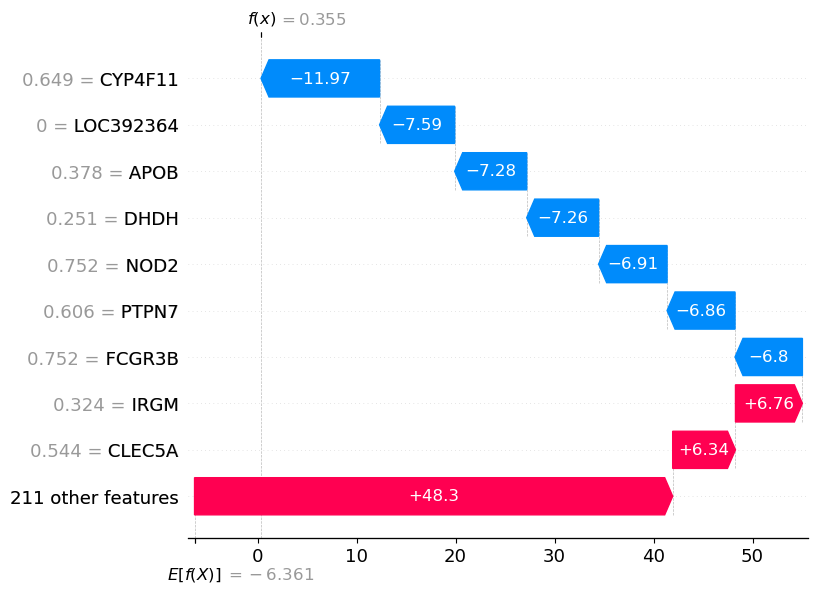

In [105]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Independent - 77

In [25]:
idx = 77

In [26]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=False, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [27]:


with open("../data/models/shap/ind_77", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [28]:
shap_values = shap_values[0]

In [29]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


In [30]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1    APOA4      APOB    APOC3      AQP9  \
Patient_ID                                                                    
256_CD_deep_ulcer  0.609459  0.598912  0.68205  0.765806  0.64835  0.450384   

                    C6   CEACAM7   CHI3L1     ABCC2  ...      MICA  LOC646430  \
Patient_ID                                           ...                        
256_CD_deep_ulcer  0.0  0.377102  0.44438  0.667302  ...  0.598137        0.0   

                   LOC441956     ITGAV   SMCHD1      ASPN    TMEM97  \
Patient_ID                                                            
256_CD_deep_ulcer        0.0  0.550635  0.71262  0.543815  0.510634   

                   LOC389458     PTPN7  RPS12P31  
Patient_ID                                        
256_CD_deep_ulcer    0.02108  0.597887       0.0  

[1 rows x 220 columns]

In [31]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(compound_model.predict(patient)[0])

Prediction probabilities for patient: [0.33333333 0.33333333 0.33333333]
Predicted class:


#### Control

In [32]:
import shap

In [33]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [34]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [35]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [36]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

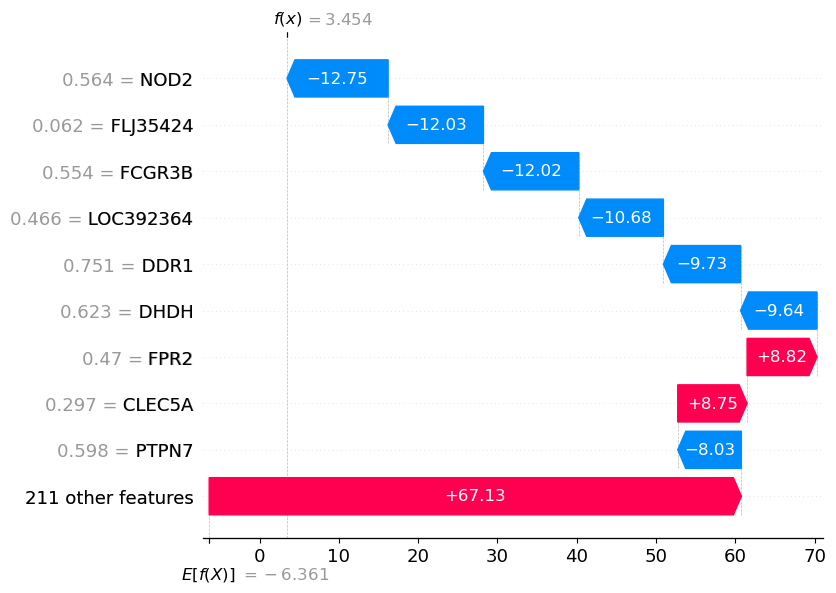

In [37]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 77

In [38]:
idx = 77

In [39]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [40]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [41]:

with open("../data/models/shap/fd_77", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [42]:
# shap_values[0][0].shape

In [43]:
shap_values = shap_values[0]

In [44]:
# shap_values[0] *= 100000

In [45]:
shap_values

[array([[  0.        ,  23.50100874,   0.        ,  65.90762829,
           0.        ,   4.20591465, -37.51589846,  29.67753812,
           0.        ,   0.        ,  -8.39378678,   5.30596393,
          -6.10288803, -16.99286877,  24.2721339 ,   0.        ,
           0.        , -32.07030243,   0.        , -31.92017819,
          -7.29068935,  56.76391996,   0.        , -25.58015653,
          10.9691045 , -34.06704161, -34.85773197, -17.18706606,
         -74.81517708, -33.76527527,   8.32061789, -41.57740627,
         -32.39658095, -34.51179369,   5.02275813,  -2.18514121,
           0.        ,  12.06499085,   0.        ,   0.        ,
         -22.01896881, -24.36575218,  17.53162919,   0.        ,
          -2.74642673,   0.        , -32.60283189,  17.70633646,
           0.        ,   0.        ,   0.        , -24.98507714,
           0.        ,   0.        ,  20.89340258,   0.        ,
          51.79214801,  17.84700901,  22.05486456,   0.        ,
         -31.32293089, -2

In [46]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [47]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1    APOA4      APOB    APOC3      AQP9  \
Patient_ID                                                                    
256_CD_deep_ulcer  0.609459  0.598912  0.68205  0.765806  0.64835  0.450384   

                    C6   CEACAM7   CHI3L1     ABCC2  ...      MICA  LOC646430  \
Patient_ID                                           ...                        
256_CD_deep_ulcer  0.0  0.377102  0.44438  0.667302  ...  0.598137        0.0   

                   LOC441956     ITGAV   SMCHD1      ASPN    TMEM97  \
Patient_ID                                                            
256_CD_deep_ulcer        0.0  0.550635  0.71262  0.543815  0.510634   

                   LOC389458     PTPN7  RPS12P31  
Patient_ID                                        
256_CD_deep_ulcer    0.02108  0.597887       0.0  

[1 rows x 220 columns]

In [48]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:",np.argmax(compound_model.predict(patient)[0])

1/1 [==============================] - 0s 101ms/step
Prediction probabilities for patient: [0.10381257 0.6050999  0.2910875 ]
Predicted class:


#### Control

In [49]:
import shap

In [50]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [51]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [52]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [55]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

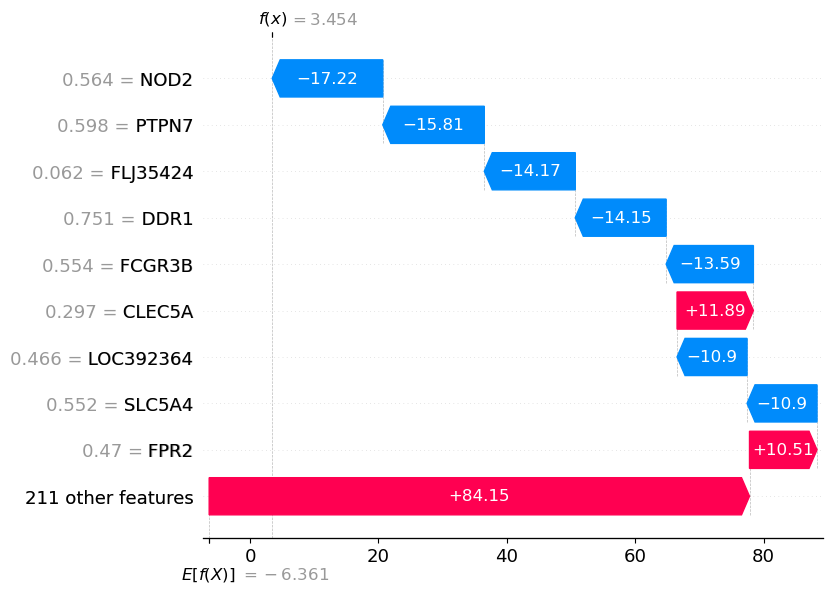

In [56]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))